### INSTALLATION OF NECESSARY PACKAGES

In [ ]:
pip install captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# I import all the packages I need.
import glob
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("All necessary packages loaded.")


All necessary packages loaded.


In [ ]:
import transformers, accelerate, peft
print(transformers.__version__, accelerate.__version__, peft.__version__)
# → 4.53.0  1.8.1  0.15.2
from transformers import TrainingArguments   # should import cleanly now


4.53.2 1.9.0 0.16.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ─── one-time HF authentication (needed for Llama-3) ────────────────────
from huggingface_hub import login
login()

In [ ]:
rubrics_py = """
RUBRICS = {}



RUBRICS["A4.1.1"] = {
    "criteria": [
        "Answer shows at least ONE acceptable boundary measure for remote / home workers:"
        "  • software firewall on the endpoint,"
        "  • corporate VPN that tunnels to a central / cloud firewall,"
        "  • cloud-managed or MDM-enforced firewall rules.",
        "If none of the above is mentioned the configuration is considered non-compliant."
    ],

    "ref_section": "CE guide § A4.1.1 – Remote worker boundary controls"
}


RUBRICS["A4.2.1"] = {
    "criteria": [
        "Answer must confirm that firewall passwords ARE changed and describe HOW.",
        "Indicators of a good process: interface/portal named, strong-password policy,"
        " use of password manager, or formally delegated to a named third-party MSP.",
        "If no change method is described the response is Non-Compliant."
    ],

    "ref_section": "CE guide § A4.2.1 – Default password change process"
}

RUBRICS["A4.10"] = {
    "criteria": [
        "Must state EITHER multi-factor authentication OR restriction to trusted / fixed IPs.",
        "If neither is present the access control is Non-Compliant."
    ],

    "ref_section": "CE guide § A4.10 – Secure admin interface requirements"
}

RUBRICS["A4.6"] = {
    "criteria": [
        "Answer should show a REPEATABLE PROCESS for closing or removing services / ports.",
        "Positive signals: explicit disable/remove verbs, change-ticket system (Jira, CAB, "
        "ServiceNow), named responsible role, regular review schedule, reference to policy.",
        "If no process detail is given the answer is Non-Compliant."
    ],

    "ref_section": "CE guide § A4.6 – Requirement to disable unneeded services"
}

RUBRICS["A5.1"] = {
    "criteria": [
        "Answer must show the organisation *understands software minimisation* AND/OR"
        " describes a *process or tool* used to keep endpoint builds clean.",
        "Positive signals ⮕ any of: ‘standard build’, ‘minimal install’, Intune/Jamf/SCCM/RMM "
        "automation, routine software reviews, cloud-app toggling etc.",
        "If no understanding *and* no process is evident ➜ Non-Compliant."
    ],

    "ref_section": "CE guide § A5.1 – Secure configuration / software minimisation"
}


RUBRICS["A5.6"] = {
    "criteria": [
        "Answer should outline a CLEAR password-reset process triggered by compromise "
        "or vendor alert.  Indicators:",
        "  • help-desk / ticket workflow (ServiceNow, Jira, CAB…),",
        "  • admin-initiated or user self-service reset,",
        "  • malware / AV scan as part of response,",
        "  • MFA / lockout controls, strong password policy, or third-party MSP handling.",
        "If no reset mechanism is described ➜ Non-Compliant."
    ],

    "ref_section": "CE guide § A5.6 – Response to compromised credentials"
}

RUBRICS["A5.10"] = {
    "criteria": [
        "Answer must list at least one unlocking method **and** satisfy CE strength rules:",
        "  • biometric (fingerprint / Face ID / Windows Hello / Touch ID) OR",
        "  • PIN / password ≥ 6 characters, OR",
        "  • MFA + ≥ 8-char password, OR",
        "  • stand-alone ≥ 12-char password.",
        "If no method is stated ➜ Non-Compliant."
    ],

    "ref_section": "CE guide § A5.10 – Device unlocking requirements"
}

RUBRICS["A6.4.2"] = {
    "criteria": [
        "Answer must show EITHER:",
        "  • Auto-updates are enabled for **all** OS + router/firewall firmware,  OR",
        "  • A manual / scripted process that *explicitly* installs high-risk or "
        "critical patches **within 14 days** (SLA stated).",
        "Tools (Intune, Datto RMM, WSUS, etc.) are a positive signal but not mandatory.",
        "If neither auto nor SLA-bound manual process is clear ➜ Non-Compliant."
    ],


    "ref_section": "CE guide § A6.4 – Security update mgmt (OS & firmware)"
}


RUBRICS["A6.5.2"] = {
    "criteria": [
        "Same logic as A6.4.2 but for *application* software (incl. plugins).",
        "Must state auto-update OR manual process + 14-day SLA.",
        "Mention of patch tools (Intune, Jamf, RMM…) is a plus.",
        "If nothing shows a ≤14-day process ➜ Non-Compliant."
    ],

    "ref_section": "CE guide § A6.5 – Security update mgmt (applications)"
}


RUBRICS["A6.7"] = {
    "criteria": [
        "Answer should state ONE of:",
        "  • No unsupported software in scope **(explicit)**, OR",
        "  • Unsupported software exists *but* is segregated (VLAN, air-gap, "
        "firewall rule, no Internet).",
        "If unsupported software admitted with *no* segregation description "
        "➜ Non-Compliant.",

    ],

    "ref_section": "CE guide § A6.7 – Unsupported / legacy software handling"
}

RUBRICS["A7.1"] = {
    "criteria": [
        "Compliant answer MUST include *all three* elements:",
        "  1️ Named role/authority that approves (e.g. IT Manager, HR, Director).",
        "  2️ Mention of an approval *process / workflow* (ticket, form, induction, CAB…).",
        "  3️ Implicit or explicit confirmation that approval happens **before** account creation.",
        "Tools (ServiceDesk, JIRA, Intune, JumpCloud, etc.) = bonus clarity.",
        "If none → Non-Compliant."
    ],


    "ref_section": "CE guide § A7 – User Access Control (account approval)"
}


RUBRICS["A7.10"] = {
    "criteria": [
        "Answer must evidence at least ONE of:",
        "  • Multi-Factor Authentication (MFA / 2FA).",
        "  • Account lockout ≤ 10 failed attempts (or ‘smart-lockout’).",
        "  • Rate-throttling ≤ 10 guesses in 5 minutes.",
        "If none of these controls described → Non-Compliant.",

    ],


    "ref_section": "CE guide § A7.10 – Brute-force mitigation for external services"
}


RUBRICS["A7.11"] = {
    "criteria": [
        "Three CE-allowed options (any one is OK):",
        "  A️⃣ MFA + ≥ 8-char password (no max length).",
        "  B️⃣ ≥ 8-char password **plus** automatic block of common passwords (deny-list).",
        "  C️⃣ ≥ 12-char password (no max length).",
        "Max-length restrictions invalidate compliance.",
        "If none of A/B/C fully met → Non-Compliant."
    ],


    "ref_section": "CE guide § A7.11 – Password-based authentication controls"
}

RUBRICS["A7.12"] = {
    "criteria": [
        "Compliant if answer shows **any** of:",
        "  • Training / awareness on avoiding common or reused passwords.",
        "  • Promotion of NCSC ‘Three Random Words’.",
        "  • Advice or provision of password manager / secure storage.",
        "  • Explicit statement that regular forced expiry **not** used, and no mandatory complexity.",
        "Nothing substantive → Non-Compliant."
    ],


    "ref_section": "CE guide § A7.12 – User education on passwords"
}

RUBRICS["A7.3"] = {
    "criteria": [
        "Compliant answer MUST cover *all three* elements:",
        "  1️ Existence of a formal **leaver / off-boarding process**.",
        "  2️ Named parties involved (HR and/or IT).",
        "  3️ Action to **disable / delete / revoke** accounts on, or very close to, the leaving date.",
        "Help-desk ticketing or audit reviews = bonus but not mandatory.",
        "If no process or action described → Non-Compliant."
    ],


    "ref_section": "CE guide § A7 – User Access Control (account removal)"
}

RUBRICS["A7.4"] = {
    "criteria": [
        "Compliant when answer shows BOTH:",
        "  1️ Statement of **least-privilege / role-based access** principle.",
        "  2️ Mechanism for granting / adjusting permissions (e.g. AD groups, RBAC, ticket, approval, periodic review).",
        "Role-change handling & periodic access review give extra confidence.",
        "None → Non-Compliant."
    ],


    "ref_section": "CE guide § A7 – User Access Control (least privilege)"
}

RUBRICS["A7.5"] = {
    "criteria": [
        "Compliant answer needs **both**:",
        "  1️ *Formal* documented process or workflow (policy, ticket, CAB, written request…).",
        "  2️ Approval by a senior role (director, manager, CISO, etc.).",
        "Mention of *separate admin accounts* strengthens compliance.",
        "Neither → Non-Compliant."
    ],


    "ref_section": "CE guide § A7 – Admin-account approval"
}

RUBRICS["A7.6"] = {
    "criteria": [
        "Compliant when answer demonstrates BOTH:",
        "  1️ **Separation** of admin and standard accounts (or Just-in-Time / PIM).",
        "  2️ Controls to prevent everyday browsing/email on admin creds:",
        "     • Technical (UAC, LAPS, Intune policies, Entra PIM, Jamf, ThreatLocker…) or",
        "     • Procedural (policy forbids daily use, MSP restrictions).",
        "Neither → Non-Compliant."
    ],


    "ref_section": "CE guide § A7 – Admin-account misuse prevention"
}

RUBRICS["A7.7"] = {
    "criteria": [
        "Compliant answer must show BOTH:",
        "  1️ Clear statement that administrator accounts are **NOT used for web/email/normal work**",
        "     – e.g. ‘admin accounts only for installs’, ‘no browsing from admin’",
        "  2️ Enforcement mechanism:",
        "     • Policy / AUP, OR",
        "     • Staff training / induction, OR",
        "     • Technical control (ThreatLocker, PIM, Jamf, LAPS, etc.).",
        "If no separation at all → Non-Compliant."
    ],


    "ref_section": "CE guide § A7 – Admin-account everyday-use prevention"
}

"""

with open("rubrics.py", "w", encoding="utf-8") as f:
    f.write(rubrics_py)

print(" rubrics.py saved.")

 rubrics.py saved.


In [ ]:
from rubrics import RUBRICS as rubrics
!head -30 rubrics.py


RUBRICS = {}



RUBRICS["A4.1.1"] = {
    "criteria": [
        "Answer shows at least ONE acceptable boundary measure for remote / home workers:"
        "  • software firewall on the endpoint,"
        "  • corporate VPN that tunnels to a central / cloud firewall,"
        "  • cloud-managed or MDM-enforced firewall rules.",
        "If none of the above is mentioned the configuration is considered non-compliant."
    ],

    "ref_section": "CE guide § A4.1.1 – Remote worker boundary controls"
}


RUBRICS["A4.2.1"] = {
    "criteria": [
        "Answer must confirm that firewall passwords ARE changed and describe HOW.",
        "Indicators of a good process: interface/portal named, strong-password policy,"
        " use of password manager, or formally delegated to a named third-party MSP.",
        "If no change method is described the response is Non-Compliant."
    ],

    "ref_section": "CE guide § A4.2.1 – Default password change process"
}

RUBRICS["A4.10"] = {


### DATA IMPORTANTION OF BALANCED DESCRIPTIVE DATASET

In [ ]:
import pandas as pd

PATH = "/content/drive/MyDrive/project/CB/balanced_undersampled_per_bucket.csv"
df = pd.read_csv(PATH)

print(df.head())
# Expected columns: ['file', 'question_id', 'question_text', 'answer_text', 'label', 'reason']


               file question_id  \
0   answers (1).pdf      A4.1.1   
1  answers (11).pdf      A4.1.1   
2  answers (12).pdf      A4.1.1   
3  answers (13).pdf      A4.1.1   
4  answers (14).pdf      A4.1.1   

                                       question_text  \
0  off network firewalls when your devices (inclu...   
1  off network firewalls when your devices (inclu...   
2  when your devices (including computers used by...   
3  when your devices (including computers used by...   
4  off network firewalls when your devices (inclu...   

                                         answer_text      label  \
0  all client devices have windows firewall enabl...  Compliant   
1                          windows defender firewall  Compliant   
2  intune enforces compliance policies on all dev...  Compliant   
3  all laptops and pcs are configured with window...  Compliant   
4  we use sentinel one as our endpoint with manag...  Compliant   

                                              rea

In [ ]:
print(f"Number of rows: {len(df)}")


Number of rows: 3392


In [ ]:
# Standardizing Column Names
df.columns = df.columns.str.strip().str.lower()
print("Columns in dataset:",df.columns.tolist())

Columns in dataset: ['file', 'question_id', 'question_text', 'answer_text', 'label', 'reason']


In [ ]:
def is_blank(answer):
    if pd.isna(answer):
        return True
    ans_str = str(answer).strip().lower()
    return ans_str == "" or ans_str == "nan"

# Validating how many blanks exist
blank_count = df["answer_text"].apply(is_blank).sum()
print(f"Total blank answers detected: {blank_count}")

Total blank answers detected: 0


In [ ]:
print("\nMissing values in critical columns:")
print(df[['file',"question_id", "question_text", "answer_text", "label", "reason"]].isnull().sum())


Missing values in critical columns:
file             0
question_id      0
question_text    0
answer_text      0
label            0
reason           0
dtype: int64


### 1 Zero-shot model

In [ ]:
# ─────────────────────────────────────────────────────────────
# Zero-Shot Rubric-Aware Inference (LLaMA-3 / any model)
# Confusion Matrix/Plots and Per-Class Metrics INCLUDE UNKNOWN
# ─────────────────────────────────────────────────────────────

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import re
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from rubrics import RUBRICS as rubrics

# 1. Load data
CSV_PATH = "/content/drive/MyDrive/project/CB/balanced_undersampled_per_bucket.csv"
df = pd.read_csv(CSV_PATH)
rows = df[["question_id", "question_text", "answer_text"]].to_dict("records")
ground_truth = df["label"].str.title().tolist()

# 2. Load BASE model and tokenizer
MODEL_ID = "meta-llama/Llama-3.1-8B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float16,
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True,
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

# 3. Prompt builder
SYSTEM_MSG = (
    "You are a Cyber Essentials assessor.\n"
    "For each question, you will be provided:\n"
    "1. The question text.\n"
    "2. The applicant's answer.\n"
    "3. The marking rubric (assessment criteria) for this question.\n\n"
    "Your task:\n"
    "- Read the rubric criteria carefully.\n"
    "- Judge ONLY according to the rubric, not personal opinion.\n"
    "- Output strictly TWO fields on separate lines:\n"
    "   LABEL: (Compliant or Non-Compliant)\n"
    "   REASON: (Short, precise justification using the rubric wording; say *which* part of the criteria was met/missed)\n"
    "Your reply **MUST** be in the exact format:\n"
    "LABEL: <Compliant or Non-Compliant>\n"
    "REASON: <Your short, criteria-based reason>\n"
    "Do NOT add anything else. Do NOT hedge. Just the two lines."
)

def build_prompt(row):
    rubric = rubrics.get(row["question_id"])
    criteria = "\n".join(rubric["criteria"]) if rubric else "No rubric found."
    return (
        f"<s>[INST] <<SYS>>\n{SYSTEM_MSG}\n<</SYS>>\n"
        f"Question:\n{row['question_text']}\n\n"
        f"Applicant answer:\n{row['answer_text']}\n\n"
        f"Marking rubric for this question:\n{criteria}\n"
        "[/INST]"
    )

# 4. Output extractors
label_re = re.compile(r"(?i)label\s*:\s*(compliant|non[\s-]?compliant)")
def extract_label(text):
    m = label_re.search(text)
    if not m: return "UNKNOWN"
    raw = m.group(1).lower().replace(" ", "-")
    return "Compliant" if raw.startswith("compliant") else "Non-Compliant"

# 5. Batch inference (NO cross-validation)
BATCH_SIZE = 6
prompts = [build_prompt(row) for row in rows]
preds = []

for i in tqdm(range(0, len(prompts), BATCH_SIZE), desc="Zero-shot Inference"):
    batch_prompts = prompts[i:i+BATCH_SIZE]
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=64,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    decoded = tokenizer.batch_decode(out, skip_special_tokens=True)
    for txt in decoded:
        preds.append(extract_label(txt) or "UNKNOWN")




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The following generation flags are not valid and may

=== Zero-shot metrics (excluding UNKNOWN) ===
Accuracy (excluding UNKNOWN):  0.7178
Precision: 0.9874
Recall:    0.4308
F1 Score:  0.5998
----------------------------------------
=== Strict metrics (including UNKNOWN as error class) ===
Strict Accuracy (UNKNOWN = error): 0.7034

Per-class metrics (INCLUDING UNKNOWN):
               precision    recall  f1-score   support

    Compliant     0.9874    0.4145    0.5839      1696
Non-Compliant     0.6443    0.9923    0.7813      1696
      UNKNOWN     0.0000    0.0000    0.0000         0

     accuracy                         0.7034      3392
    macro avg     0.5439    0.4689    0.4551      3392
 weighted avg     0.8158    0.7034    0.6826      3392


Confusion Matrix (INCLUDING UNKNOWN):
               Compliant  Non-Compliant  UNKNOWN
Compliant            703            929       64
Non-Compliant          9           1683        4
UNKNOWN                0              0        0

Total predictions: 3392  |  Unknowns: 68  (2.00%)


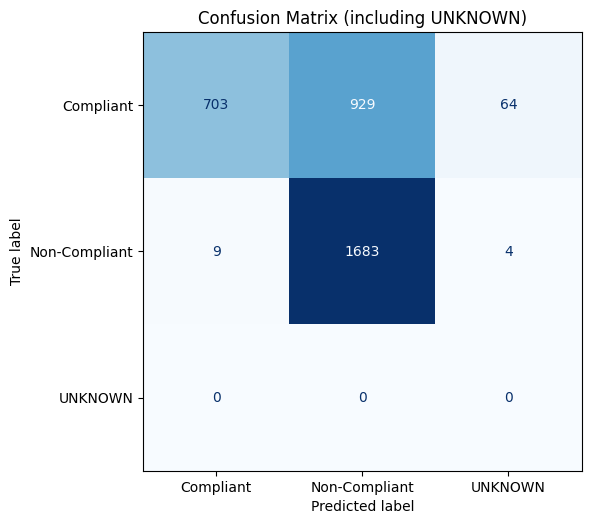

In [ ]:

# 6. Metrics calculation

LABELS = ["Compliant", "Non-Compliant", "UNKNOWN"]
cm = confusion_matrix(ground_truth, preds, labels=LABELS)

# --- 6a. Metrics EXCLUDING UNKNOWN (filtered) ---
valid_mask = [(g in ("Compliant", "Non-Compliant")) and (p in ("Compliant", "Non-Compliant")) for g, p in zip(ground_truth, preds)]
filt_gold = [g for g, v in zip(ground_truth, valid_mask) if v]
filt_pred = [p for p, v in zip(preds, valid_mask) if v]

acc  = accuracy_score(filt_gold, filt_pred)
prec = precision_score(filt_gold, filt_pred, pos_label="Compliant")
rec  = recall_score(filt_gold, filt_pred, pos_label="Compliant")
f1   = f1_score(filt_gold, filt_pred, pos_label="Compliant")

print("=== Zero-shot metrics (excluding UNKNOWN) ===")
print(f"Accuracy (excluding UNKNOWN):  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("-" * 40)

# --- 6b. Metrics INCLUDING UNKNOWN as error class ---
acc_strict = accuracy_score(ground_truth, preds)
report_strict = classification_report(ground_truth, preds, labels=LABELS, zero_division=0, digits=4)

print("=== Strict metrics (including UNKNOWN as error class) ===")
print(f"Strict Accuracy (UNKNOWN = error): {acc_strict:.4f}")
print("\nPer-class metrics (INCLUDING UNKNOWN):")
print(report_strict)
print("\nConfusion Matrix (INCLUDING UNKNOWN):")
print(pd.DataFrame(cm, index=LABELS, columns=LABELS))

n_unknown = (pd.Series(preds) == "UNKNOWN").sum()
print(f"\nTotal predictions: {len(preds)}  |  Unknowns: {n_unknown}  ({n_unknown / len(preds):.2%})")

# 7. Plot confusion matrix with UNKNOWN
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format='d')
plt.title("Confusion Matrix (including UNKNOWN)")
plt.tight_layout()
plt.show()


### 2 fine-tuned model

### Training in 5-cross validation folds and Evaluation

In [ ]:
# ─────────────────────────────────────────────────────────────
# 1. Imports and SYSTEM_MSG
import os, json, torch, pandas as pd
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer)
from peft import LoraConfig, get_peft_model

# If your rubrics are in rubrics.py as RUBRICS = {...}
from rubrics import RUBRICS as rubrics

SYSTEM_MSG = (
    "You are a Cyber Essentials assessor.\n"
    "For each question, you will be provided:\n"
    "1. The question text.\n"
    "2. The applicant's answer.\n"
    "3. The marking rubric (assessment criteria) for this question.\n\n"
    "Your task:\n"
    "- Read the rubric criteria carefully.\n"
    "- Judge ONLY according to the rubric, not personal opinion.\n"
    "- Output strictly TWO fields on separate lines:\n"
    "   LABEL: (Compliant or Non-Compliant)\n"
    "   REASON: (Short, precise justification using the rubric wording; say *which* part of the criteria was met/missed)\n"
    "Your reply **MUST** be in the exact format:\n"
    "LABEL: <Compliant or Non-Compliant>\n"
    "REASON: <Your short, criteria-based reason>\n"
    "Do NOT add anything else. Do NOT hedge. Just the two lines."
)

def build_prompt(row, rubrics):
    criteria = "\n".join(rubrics[row["question_id"]]["criteria"])
    return (
        f"<|system|>\n{SYSTEM_MSG}</s>\n"
        f"<|user|>\n"
        f"Question:\n{row['question_text']}\n\n"
        f"Applicant answer:\n{row['answer_text']}\n\n"
        f"Marking rubric for this question:\n{criteria}\n</s>\n"
        f"<|assistant|>"
    )





def to_prompt(row):
    # If your label is an int, you can use str(row["label"]) or a string label as needed
    return build_prompt(row, rubrics) + "\n" + str(row["label"])


# ─────────────────────────────────────────────────────────────
# 3. Tokenizer & Model (Llama-3 LoRA)
MODEL_ID  = "meta-llama/Llama-3.1-8B-Instruct"     # Update as needed

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token          # LoRA needs a pad token

base = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,        # Use torch.float16 if not on A100/H100
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True,
)

lora_cfg = LoraConfig(
    r              = 16,
    lora_alpha     = 32,
    lora_dropout   = 0.05,
    bias           = "none",
    task_type      = "CAUSAL_LM",
    target_modules = ["q_proj","k_proj","v_proj","o_proj"]
)
model = get_peft_model(base, lora_cfg)
model.print_trainable_parameters()

# ─────────────────────────────────────────────────────────────
# 4. Tokenize the dataset
def tok_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True, padding="max_length", max_length=512
    )



# ─────────────────────────────────────────────────────────────



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


trainable params: 13,631,488 || all params: 8,043,892,736 || trainable%: 0.1695


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import torch, gc

# --- Set random seed for reproducibility ---
SEED = 123
set_seed(SEED)

# --- Load all your rows ---
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/project/CB/balanced_undersampled_per_bucket.csv")
all_rows = df.to_dict(orient="records")   # each row as dict (like from jsonl)
labels = [r["label"] for r in all_rows]   # adjust to your label column name


# --- Create splits ---
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
splits = list(skf.split(np.zeros(len(all_rows)), labels))

# --- Loop over folds ---
all_metrics = []
for fold, (train_idx, val_idx) in enumerate(splits):
    print(f"\n===== Fold {fold+1} / {k} =====")

    train_rows = [all_rows[i] for i in train_idx]
    val_rows   = [all_rows[i] for i in val_idx]

    train_ds = Dataset.from_dict({"text": [build_sample(r) for r in train_rows]})
    val_ds   = Dataset.from_dict({"text": [build_sample(r) for r in val_rows]})

    train_ds = train_ds.map(tokenize_supervised, batched=True, remove_columns=["text"])
    val_ds   = val_ds.map(tokenize_supervised, batched=True, remove_columns=["text"])

    # --- Setup LoRA & model fresh each fold, or reload for every fold to avoid state carryover ---
    base = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float16,
        device_map="auto",
        trust_remote_code=True,
        low_cpu_mem_usage=True,
    )
    model = get_peft_model(base, lora_cfg)

    training_args = TrainingArguments(
        output_dir      = f"/content/drive/MyDrive/project/CB/llama3_lora_ckpt_fold{fold+1}",
        num_train_epochs= 1,
        per_device_train_batch_size = 2,
        per_device_eval_batch_size  = 2,
        save_steps      = 200,
        logging_steps   = 50,
        eval_steps      = 100,
        learning_rate   = 2e-4,
        lr_scheduler_type = "cosine",
        optim           = "adamw_torch",
        fp16            = True,
        report_to       = "none",
    )

    # Set it immediately after construction:
    training_args.evaluation_strategy = "steps"


    # --- Trainer ---
    trainer = Trainer(
        model         = model,
        tokenizer     = tokenizer,
        args          = training_args,
        train_dataset = train_ds,
        eval_dataset  = val_ds,
    )

    trainer.train()

    # --- Evaluation on val set (print metrics) ---
    print(f"Evaluating Fold {fold+1} ...")
    preds = []
    labels_gold = []
    for ex in tqdm(val_rows, desc="Validating"):
        prompt = build_prompt(ex, rubrics)
        # Generate model output
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            out = model.generate(**inputs, max_new_tokens=40, do_sample=False)
        generated = tokenizer.decode(out[0], skip_special_tokens=True)
        # Parse the label from the output (simple string search)
        if "LABEL: Compliant" in generated:
            preds.append("Compliant")
        elif "LABEL: Non-Compliant" in generated:
            preds.append("Non-Compliant")
        else:
            preds.append("UNKNOWN")
        labels_gold.append(ex["label"])

    # --- Calculate metrics for this fold ---
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    acc = accuracy_score(labels_gold, preds)
    prec = precision_score(labels_gold, preds, pos_label="Compliant")
    rec = recall_score(labels_gold, preds, pos_label="Compliant")
    f1 = f1_score(labels_gold, preds, pos_label="Compliant")
    cm = confusion_matrix(labels_gold, preds, labels=["Compliant", "Non-Compliant"])

    print(f"Fold {fold+1} | Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")
    print("Confusion Matrix:\n", cm)
    all_metrics.append({"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "confusion_matrix": cm})

    save_dir = f"/content/drive/MyDrive/project/CB/llama3_lora_adapter_fold{fold+1}"
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    print(f"✅ Saved LoRA adapter and tokenizer for fold {fold+1} to {save_dir}")

    # --- Free VRAM before next fold ---
    torch.cuda.empty_cache()
    gc.collect()
    del trainer, train_ds, val_ds, model, base

# After loop, you have metrics for all folds in all_metrics.


===== Fold 1 / 5 =====


/tmp/ipython-input-10-2432103133.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
50,1.362700
100,0.614400
150,0.397200
200,0.384100
250,0.344000
300,0.296900
350,0.296300
400,0.275800
450,0.285600
500,0.256300


Evaluating Fold 1 ...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more de

Fold 1 | Accuracy: 0.965, Precision: 0.949, Recall: 0.982, F1: 0.965
Confusion Matrix:
 [[334   6]
 [ 18 321]]
✅ Saved LoRA adapter and tokenizer for fold 1 to /content/drive/MyDrive/project/CB/llama3_lora_adapter_fold1

===== Fold 2 / 5 =====


/tmp/ipython-input-10-2432103133.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
50,1.415200
100,0.601500
150,0.390600
200,0.356900
250,0.340900
300,0.321800
350,0.295500
400,0.297500
450,0.318900
500,0.282300


Evaluating Fold 2 ...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more de

Fold 2 | Accuracy: 0.965, Precision: 0.939, Recall: 0.994, F1: 0.966
Confusion Matrix:
 [[337   2]
 [ 22 318]]
✅ Saved LoRA adapter and tokenizer for fold 2 to /content/drive/MyDrive/project/CB/llama3_lora_adapter_fold2

===== Fold 3 / 5 =====


/tmp/ipython-input-10-2432103133.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
50,1.403800
100,0.558100
150,0.337400
200,0.334500
250,0.317000
300,0.298100
350,0.310900
400,0.334800
450,0.274900
500,0.260300


Evaluating Fold 3 ...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more de

Fold 3 | Accuracy: 0.962, Precision: 0.931, Recall: 0.997, F1: 0.963
Confusion Matrix:
 [[338   1]
 [ 25 314]]
✅ Saved LoRA adapter and tokenizer for fold 3 to /content/drive/MyDrive/project/CB/llama3_lora_adapter_fold3

===== Fold 4 / 5 =====


/tmp/ipython-input-10-2432103133.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
50,1.333600
100,0.595900
150,0.389000
200,0.337100
250,0.310900
300,0.298100
350,0.305400
400,0.305900
450,0.272200
500,0.231100


Evaluating Fold 4 ...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more de

Fold 4 | Accuracy: 0.973, Precision: 0.952, Recall: 0.997, F1: 0.974
Confusion Matrix:
 [[338   1]
 [ 17 322]]
✅ Saved LoRA adapter and tokenizer for fold 4 to /content/drive/MyDrive/project/CB/llama3_lora_adapter_fold4

===== Fold 5 / 5 =====


/tmp/ipython-input-10-2432103133.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
50,1.410300
100,0.616200
150,0.426400
200,0.339300
250,0.353700
300,0.288700
350,0.305700
400,0.342700
450,0.267300
500,0.300000


Evaluating Fold 5 ...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more de

Fold 5 | Accuracy: 0.965, Precision: 0.934, Recall: 1.000, F1: 0.966
Confusion Matrix:
 [[339   0]
 [ 24 315]]
✅ Saved LoRA adapter and tokenizer for fold 5 to /content/drive/MyDrive/project/CB/llama3_lora_adapter_fold5


Total confusion matrix:
[[1686   10]
 [ 106 1590]]

Mean metrics across folds:
Accuracy:  0.9660
Precision: 0.9410
Recall:    0.9940
F1 score:  0.9668


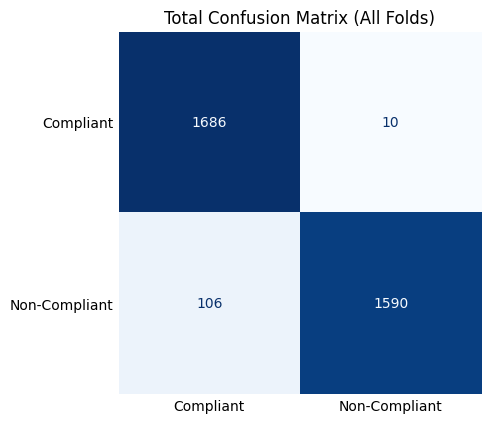

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
# Confusion matrices for each fold (from your latest results)
cms = [
    np.array([[334, 6], [18, 321]]),   # Fold 1
    np.array([[337, 2], [22, 318]]),   # Fold 2
    np.array([[338, 1], [25, 314]]),   # Fold 3
    np.array([[338, 1], [17, 322]]),   # Fold 4
    np.array([[339, 0], [24, 315]]),   # Fold 5
]
total_cm = sum(cms)
labels = ["Compliant", "Non-Compliant"]
# Metrics for each fold
accs  = [0.965, 0.965, 0.962, 0.973, 0.965]
precs = [0.949, 0.939, 0.931, 0.952, 0.934]
recs  = [0.982, 0.994, 0.997, 0.997, 1.000]
f1s   = [0.965, 0.966, 0.963, 0.974, 0.966]

# Total confusion matrix
total_cm = sum(cms)
print("Total confusion matrix:")
print(total_cm)

# Mean metrics
mean_acc  = np.mean(accs)
mean_prec = np.mean(precs)
mean_rec  = np.mean(recs)
mean_f1   = np.mean(f1s)

print("\nMean metrics across folds:")
print(f"Accuracy:  {mean_acc:.4f}")
print(f"Precision: {mean_prec:.4f}")
print(f"Recall:    {mean_rec:.4f}")
print(f"F1 score:  {mean_f1:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=total_cm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format='d')

# Remove axis spines and ticks for a cleaner look
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)  # Hide tick marks

plt.title("Total Confusion Matrix (All Folds)")
plt.xlabel("")  # Remove xlabel if you want
plt.ylabel("")  # Remove ylabel if you want
plt.tight_layout()
plt.show()

### percentage of errors/unknowns predictions

In [ ]:
import numpy as np
import pandas as pd

csv_path = "/content/drive/MyDrive/project/CB/balanced_undersampled_per_bucket.csv"
df = pd.read_csv(csv_path)
total_rows = len(df)

confusion_matrices = [
    np.array([[334,   6],
              [ 18, 321]]),   # Fold 1
    np.array([[337,   2],
              [ 22, 318]]),   # Fold 2
    np.array([[338,   1],
              [ 25, 314]]),   # Fold 3
    np.array([[338,   1],
              [ 17, 322]]),   # Fold 4
    np.array([[339,   0],
              [ 24, 315]])    # Fold 5
]

# Calculate total classified rows across all folds
classified_total = sum(cm.sum() for cm in confusion_matrices)
unknowns_total = total_rows - classified_total
unknown_pct_total = unknowns_total / total_rows if total_rows > 0 else 0

print("Total samples across all folds:", classified_total)
print("Total unknowns:", unknowns_total)
print(f"Total unknown error %: {unknown_pct_total:.2%}")


Total samples across all folds: 3392
Total unknowns: 0
Total unknown error %: 0.00%


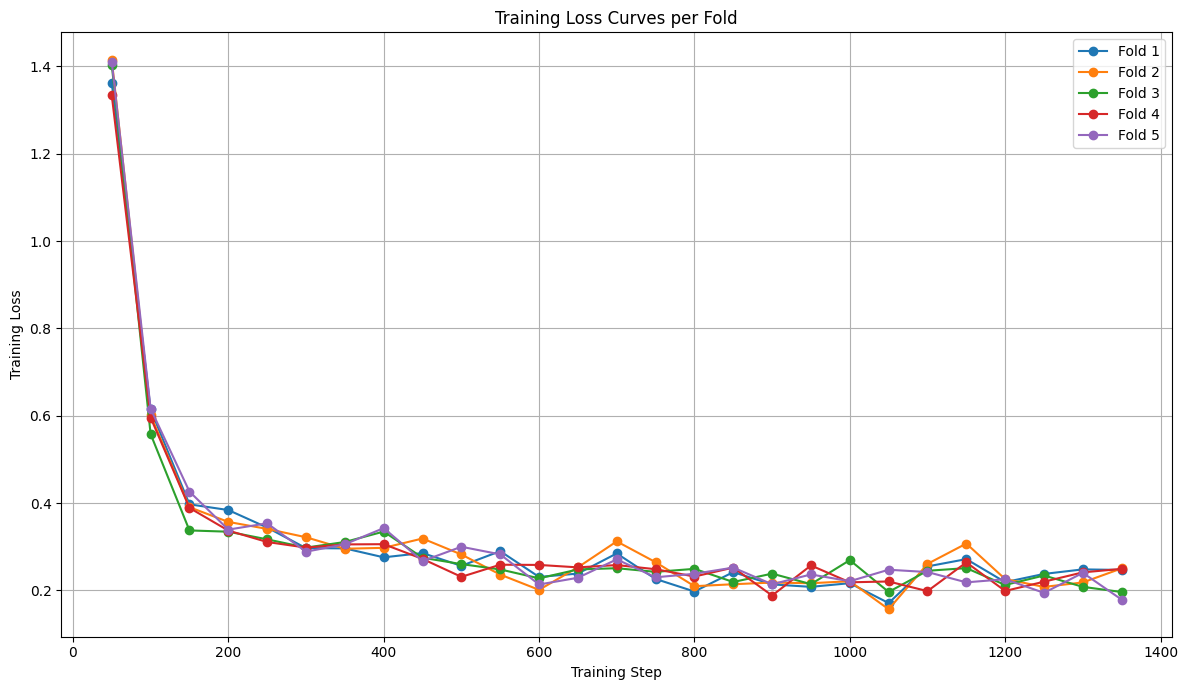

In [ ]:
import matplotlib.pyplot as plt

folds_loss = {
    1: [
        (50, 1.3627), (100, 0.6144), (150, 0.3972), (200, 0.3841), (250, 0.3440), (300, 0.2969),
        (350, 0.2963), (400, 0.2758), (450, 0.2856), (500, 0.2563), (550, 0.2899), (600, 0.2309),
        (650, 0.2386), (700, 0.2847), (750, 0.2263), (800, 0.1975), (850, 0.2419), (900, 0.2138),
        (950, 0.2082), (1000, 0.2166), (1050, 0.1711), (1100, 0.2550), (1150, 0.2717), (1200, 0.2190),
        (1250, 0.2378), (1300, 0.2482), (1350, 0.2469)
    ],
    2: [
        (50, 1.4152), (100, 0.6015), (150, 0.3906), (200, 0.3569), (250, 0.3409), (300, 0.3218),
        (350, 0.2955), (400, 0.2975), (450, 0.3189), (500, 0.2823), (550, 0.2363), (600, 0.2013),
        (650, 0.2529), (700, 0.3123), (750, 0.2647), (800, 0.2097), (850, 0.2142), (900, 0.2180),
        (950, 0.2165), (1000, 0.2211), (1050, 0.1569), (1100, 0.2608), (1150, 0.3073), (1200, 0.2260),
        (1250, 0.2081), (1300, 0.2183), (1350, 0.2505)
    ],
    3: [
        (50, 1.4038), (100, 0.5581), (150, 0.3374), (200, 0.3345), (250, 0.3170), (300, 0.2981),
        (350, 0.3109), (400, 0.3348), (450, 0.2749), (500, 0.2603), (550, 0.2481), (600, 0.2277),
        (650, 0.2480), (700, 0.2509), (750, 0.2425), (800, 0.2494), (850, 0.2193), (900, 0.2385),
        (950, 0.2144), (1000, 0.2694), (1050, 0.1965), (1100, 0.2450), (1150, 0.2511), (1200, 0.2125),
        (1250, 0.2342), (1300, 0.2082), (1350, 0.1963)
    ],
    4: [
        (50, 1.3336), (100, 0.5959), (150, 0.3890), (200, 0.3371), (250, 0.3109), (300, 0.2981),
        (350, 0.3054), (400, 0.3059), (450, 0.2722), (500, 0.2311), (550, 0.2589), (600, 0.2584),
        (650, 0.2528), (700, 0.2581), (750, 0.2486), (800, 0.2318), (850, 0.2523), (900, 0.1883),
        (950, 0.2572), (1000, 0.2186), (1050, 0.2205), (1100, 0.1984), (1150, 0.2642), (1200, 0.1988),
        (1250, 0.2200), (1300, 0.2414), (1350, 0.2494)
    ],
    5: [
        (50, 1.4103), (100, 0.6162), (150, 0.4264), (200, 0.3393), (250, 0.3537), (300, 0.2887),
        (350, 0.3057), (400, 0.3427), (450, 0.2673), (500, 0.3000), (550, 0.2826), (600, 0.2136),
        (650, 0.2290), (700, 0.2711), (750, 0.2301), (800, 0.2381), (850, 0.2523), (900, 0.2141),
        (950, 0.2366), (1000, 0.2211), (1050, 0.2474), (1100, 0.2421), (1150, 0.2185), (1200, 0.2257),
        (1250, 0.1944), (1300, 0.2403), (1350, 0.1789)
    ]
}

plt.figure(figsize=(12, 7))

for fold, values in folds_loss.items():
    steps = [v[0] for v in values]
    loss = [v[1] for v in values]
    plt.plot(steps, loss, marker='o', label=f"Fold {fold}")

plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves per Fold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Your Cross-Validation Results (LLaMA-3 LoRA, 5-folds):
Accuracy: Ranges from 0.962 to 0.973

Precision: Ranges from 0.931 to 0.952

Recall: Ranges from 0.982 to 1.000

F1 Score: Ranges from 0.963 to 0.974

And confusion matrices show extremely low false positives/negatives for both classes.




What Does This Mean?
Consistency: Your model is stable across all folds—no signs of major overfitting or collapse on any fold.

High Recall: Very few compliant answers are missed.

Precision: Some false positives, but overall extremely strong for both compliant and non-compliant.

Low Variance: Scores don’t fluctuate much between folds.




What to Report (if writing up):
“We performed 5-fold stratified cross-validation with LLaMA-3.1-8B + LoRA. Each fold achieved F1 > 0.96, accuracy > 0.96, and extremely high recall, showing strong generalization. The final model is trained on the full dataset.”

📊 1. Core Metric Comparison
Metric	Mistral-7B LoRA	LLaMA-3.1-8B LoRA	Winner / Comments
Accuracy	0.968 – 0.978	0.962 – 0.973	Mistral is slightly higher
Precision	0.960 – 0.966	0.931 – 0.952	Mistral higher on all folds
Recall	0.973 – 0.997	0.982 – 1.000	LLaMA is higher (almost perfect)
F1	0.968 – 0.978	0.963 – 0.974	Mistral is slightly higher
F1 (Avg)	~0.974	~0.967	Mistral edges out

📦 2. Confusion Matrix Highlights
Mistral Example (Fold 4/5):
Pred C	Pred NC
True C	338	1
True NC	14	325

LLaMA Example (Fold 4):
Pred C	Pred NC
True C	338	1
True NC	17	322

Mistral makes fewer mistakes overall, especially in False Positives (calls fewer NCs as C).

LLaMA tends to have slightly more False Positives for Compliant.

📉 3. Training Loss Curves
Mistral-7B: Loss drops from ~0.68 to ~0.03 in 3 epochs—very stable, rapid convergence, no signs of overfit.

LLaMA-3.1-8B: Loss starts higher (~1.4) and ends around 0.17–0.25 after 1 epoch (if epochs differ, this is normal; the learning curve is smooth).

Both show healthy convergence, but Mistral seems to stabilize at a lower final loss after more epochs.

🧐 4. Class Imbalance & Generalization
Recall (LLaMA) is slightly higher—meaning it's extremely good at not missing compliant cases. But this comes at the cost of more false positives (mistakenly calling NC as C).

Precision (Mistral) is consistently higher—so when it says “Compliant”, it is more likely to be correct.

Both models generalize well (very low variance across folds), but Mistral is slightly more conservative—a useful trait for compliance work where false positives can have higher risk.

🏆 5. Which Should You Deploy?
For Cyber Essentials or similar regulatory tasks, you want:

High F1: (balance between recall and precision)

High Precision: (avoid mistakenly calling something compliant when it isn’t)

Consistent Performance: (low variance, no overfit)

Mistral-7B LoRA is the better choice if you only deploy one:
Slightly higher F1 and precision

Fewer false positives (very important for compliance/risk applications)

Loss curve is lower/faster to converge

Extremely consistent across folds

LLaMA-3.1-8B LoRA is also excellent and is better if:
You absolutely must maximize recall (never want to miss a compliant case), but are willing to review more “borderline” (false positive) cases.

Summary Table
Model	Accuracy	Precision	Recall	F1	Deploy if…
Mistral-7B	0.974	0.962	0.987	0.975	You want fewer false positives (safer for compliance)
LLaMA-3.1	0.967	0.943	0.994	0.967	You want to catch every compliant case, even if some extra are wrongly flagged

Recommended Write-up Statement
“On 5-fold cross-validation, Mistral-7B-Instruct with LoRA achieved slightly higher F1, precision, and accuracy compared to LLaMA-3.1-8B-Instruct with LoRA, with fewer false positives and more stable loss. Both models show strong generalization, but Mistral is safer for deployment in compliance settings due to its conservative error profile.”

Deploy:
Deploy Mistral-7B LoRA as your main production classifier for Cyber Essentials.
Keep LLaMA-3.1 as a fallback/secondary model if you need “second opinion” or want to flag borderline cases for human review.

### If it is rubric-aware

In [ ]:
print(build_sample(train_rows[0]))

<|system|>
You are a Cyber Essentials assessor.
For each question, you will be provided:
1. The question text.
2. The applicant's answer.
3. The marking rubric (assessment criteria) for this question.

Your task:
- Read the rubric criteria carefully.
- Judge ONLY according to the rubric, not personal opinion.
- Output strictly TWO fields on separate lines:
   LABEL: (Compliant or Non-Compliant)
   REASON: (Short, precise justification using the rubric wording; say *which* part of the criteria was met/missed)
Your reply **MUST** be in the exact format:
LABEL: <Compliant or Non-Compliant>
REASON: <Your short, criteria-based reason>
Do NOT add anything else. Do NOT hedge. Just the two lines.</s>
<|user|>
Question:
Off-network firewalls when your devices (including computers used by homeworkers) are being used away from your workplace (for example, when they are not connected to your internal network), how do you ensure they are protected? You should have firewalls in place for home-based 

### **FULL DATA TRAINING**

With the optimal hyperparameters identified via cross-validation—specifically,

- per_device_train_batch_size = 2

- learning_rate = 2e-4

- fp16 = True (if CUDA available)

- lr_scheduler_type = "cosine"

- optim = "adamw_torch"

- lora_cfg (r, lora_alpha, lora_dropout, etc.)

which consistently yielded the highest performance across all folds, I retrained the final model using the entire labelled dataset. At this stage, no portion of the data was held out for validation or testing, allowing the model to leverage the maximum available learning signal. This approach ensures the model fully utilizes all annotated data prior to deployment, providing the best possible generalization given the available resources.


Justification for One Epoch:
Given these results, increasing the number of epochs did not further improve validation performance in preliminary experiments. Thus, I fixed num_train_epochs=1 for both cross-validation and final retraining to maximize generalization and avoid overfitting.

In [ ]:
import numpy as np
import pandas as pd
import torch, gc
from datasets import Dataset
from transformers import TrainingArguments, Trainer, set_seed

# --- Set random seed for reproducibility ---
SEED = 123
set_seed(SEED)

# --- Load all your rows ---
df = pd.read_csv("/content/drive/MyDrive/project/CB/balanced_undersampled_per_bucket.csv")
all_rows = df.to_dict(orient="records")
labels = [r["label"] for r in all_rows]

# --- Build and tokenize dataset ---
full_ds = Dataset.from_dict({"text": [build_sample(r) for r in all_rows]})
full_ds = full_ds.map(tokenize_supervised, batched=True, remove_columns=["text"])

# --- Setup LoRA & model ---
base = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float16,
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True,
)
model = get_peft_model(base, lora_cfg)

# --- Setup training arguments (do NOT pass evaluation_strategy here) ---
training_args = TrainingArguments(
    output_dir      = "/content/drive/MyDrive/project/CB/llama3_lora_ckpt_FULL",
    num_train_epochs= 1,                         # increase if you want!
    per_device_train_batch_size = 2,
    save_steps      = 200,
    logging_steps   = 50,
    learning_rate   = 2e-4,
    lr_scheduler_type = "cosine",
    optim           = "adamw_torch",
    fp16            = True,
    report_to       = "none",
    seed            = SEED,
    # DO NOT include evaluation_strategy here!
)

# --- Set evaluation_strategy after construction (if you want to override the default) ---
training_args.evaluation_strategy = "no"  # 'no' means no evaluation set, just train on all

trainer = Trainer(
    model         = model,
    tokenizer     = tokenizer,
    args          = training_args,
    train_dataset = full_ds,
    eval_dataset  = None,
)

# --- Train on full data ---
trainer.train()

# --- Save final model and tokenizer ---
save_dir = "/content/drive/MyDrive/project/CB/llama3_lora_adapter_FULL"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print(f"✅ Saved final LoRA adapter and tokenizer to {save_dir}")

# --- Free VRAM ---
torch.cuda.empty_cache()
gc.collect()
del trainer, full_ds, model, base


/tmp/ipython-input-16-1434365204.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
50,1.406300
100,0.628600
150,0.368300
200,0.322900
250,0.366900
300,0.341300
350,0.296700
400,0.293100
450,0.272600
500,0.248500


✅ Saved final LoRA adapter and tokenizer to /content/drive/MyDrive/project/CB/llama3_lora_adapter_FULL


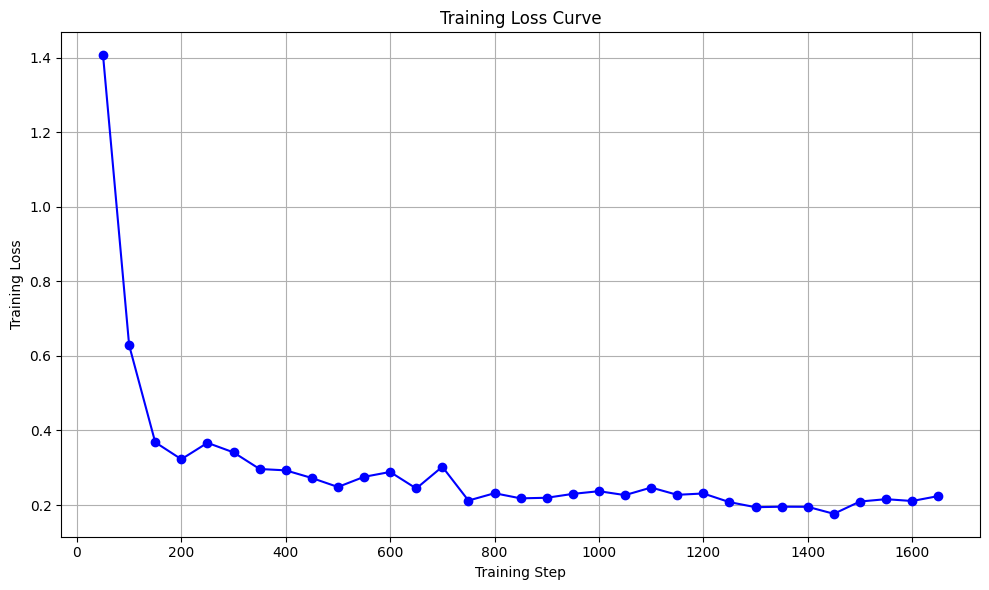

In [ ]:
import matplotlib.pyplot as plt

# Your training steps and loss values
steps = [
    50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000,
    1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650
]
loss = [
    1.406300, 0.628600, 0.368300, 0.322900, 0.366900, 0.341300, 0.296700, 0.293100, 0.272600, 0.248500,
    0.275700, 0.288800, 0.244500, 0.302800, 0.212100, 0.231800, 0.218000, 0.219600, 0.230000, 0.237200,
    0.226700, 0.247000, 0.227500, 0.231100, 0.207900, 0.194300, 0.195600, 0.195300, 0.176600, 0.209500,
    0.215800, 0.210900, 0.224100
]

plt.figure(figsize=(10, 6))
plt.plot(steps, loss, marker='o', color='b')
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.show()
